In [611]:
"""
First lets get the common libraries here in play
"""
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

In [612]:
#Store the data
data = pd.read_csv('./data/MTA_Subway_Stations_20241127.csv')
data.head()

,GTFS Stop ID,Station ID,Complex ID,Division,Line,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
0,R01,1,1,BMT,Astoria,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,Last Stop,Manhattan,0,0,0,NaN,POINT (-73.912034 40.775036)
1,R03,2,2,BMT,Astoria,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,Astoria,Manhattan,1,1,1,NaN,POINT (-73.917843 40.770258)
2,R04,3,3,BMT,Astoria,30 Av,Q,False,N W,Elevated,40.766779,-73.921479,Astoria,Manhattan,0,0,0,NaN,POINT (-73.921479 40.766779)
3,R05,4,4,BMT,Astoria,Broadway,Q,False,N W,Elevated,40.761820,-73.925508,Astoria,Manhattan,0,0,0,NaN,POINT (-73.925508 40.76182)
4,R06,5,5,BMT,Astoria,36 Av,Q,False,N W,Elevated,40.756804,-73.929575,Astoria,Manhattan,0,0,0,NaN,POINT (-73.929575 40.756804)


In [613]:
f_train = data[data['Daytime Routes'].str.contains('F')]
f_train.head()

,GTFS Stop ID,Station ID,Complex ID,Division,Line,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
56,D42,57,57,BMT,Broadway - Brighton,W 8 St-NY Aquarium,Bk,False,F Q,Elevated,40.576127,-73.975939,Manhattan,Coney Island,0,0,0,NaN,POINT (-73.975939 40.576127)
57,D43,58,58,BMT,Sea Beach / West End / Culver / Brighton,Coney Island-Stillwell Av,Bk,False,D F N Q,Viaduct,40.577422,-73.981233,Manhattan,Last Stop,1,1,1,NaN,POINT (-73.981233 40.577422)
167,D20,167,167,IND,6th Av - Culver,W 4 St-Wash Sq,M,True,B D F M,Subway,40.732338,-74.000495,Uptown,Downtown,1,1,1,NaN,POINT (-74.000495 40.732338)
174,A41,174,636,IND,8th Av - Fulton St,Jay St-MetroTech,Bk,False,A C F,Subway,40.692338,-73.987342,Manhattan,Outbound,1,1,1,NaN,POINT (-73.987342 40.692338)
221,B04,221,221,IND,63rd St,21 St-Queensbridge,Q,False,F,Subway,40.754203,-73.942836,Outbound,Manhattan,1,1,1,NaN,POINT (-73.942836 40.754203)


In [614]:
"""
Info about the F Train
"""
print(f'Number of F train Stations:', len(f_train))

Number of F train Stations: 45


We want to actually have them connected by the closest station on the line

In [615]:
# Create array of coordinates
coords = f_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Function to find path using nearest neighbor
def nearest_neighbor_path(distance_matrix, start=0):
    n = len(distance_matrix)
    path = [start]
    unvisited = set(range(n))
    unvisited.remove(start)
    
    while unvisited:
        current = path[-1]
        # Find the nearest unvisited station
        next_stop = min(unvisited, key=lambda x: distance_matrix[current][x])
        path.append(next_stop)
        unvisited.remove(next_stop)
    
    return path

def swap_rows(df, idx1, idx2):
    """Swap two rows in a DataFrame"""
    df.iloc[idx1], df.iloc[idx2] = df.iloc[idx2].copy(), df.iloc[idx1].copy()
    return df

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix)

# Create a new DataFrame with the stations in the path order
f_train_ordered = f_train.iloc[path].reset_index(drop=True)
f_train_ordered = swap_rows(f_train_ordered, 0, 2)

# Display the first few rows to verify the ordering
print("F train stations in geographical order:")
print(f_train_ordered[['Stop Name', 'Borough', 'GTFS Latitude', 'GTFS Longitude']].head())
# Optional: Save this ordered version if needed
# f_train_ordered.to_csv('f_train_ordered.csv', index=False)

F train stations in geographical order:
                   Stop Name Borough  GTFS Latitude  GTFS Longitude
0  Coney Island-Stillwell Av      Bk      40.577422      -73.981233
1                 Neptune Av      Bk      40.581011      -73.974574
2         W 8 St-NY Aquarium      Bk      40.576127      -73.975939
3                   Avenue X      Bk      40.589620      -73.974250
4                   Avenue U      Bk      40.596063      -73.973357


This is the plot for the F train.

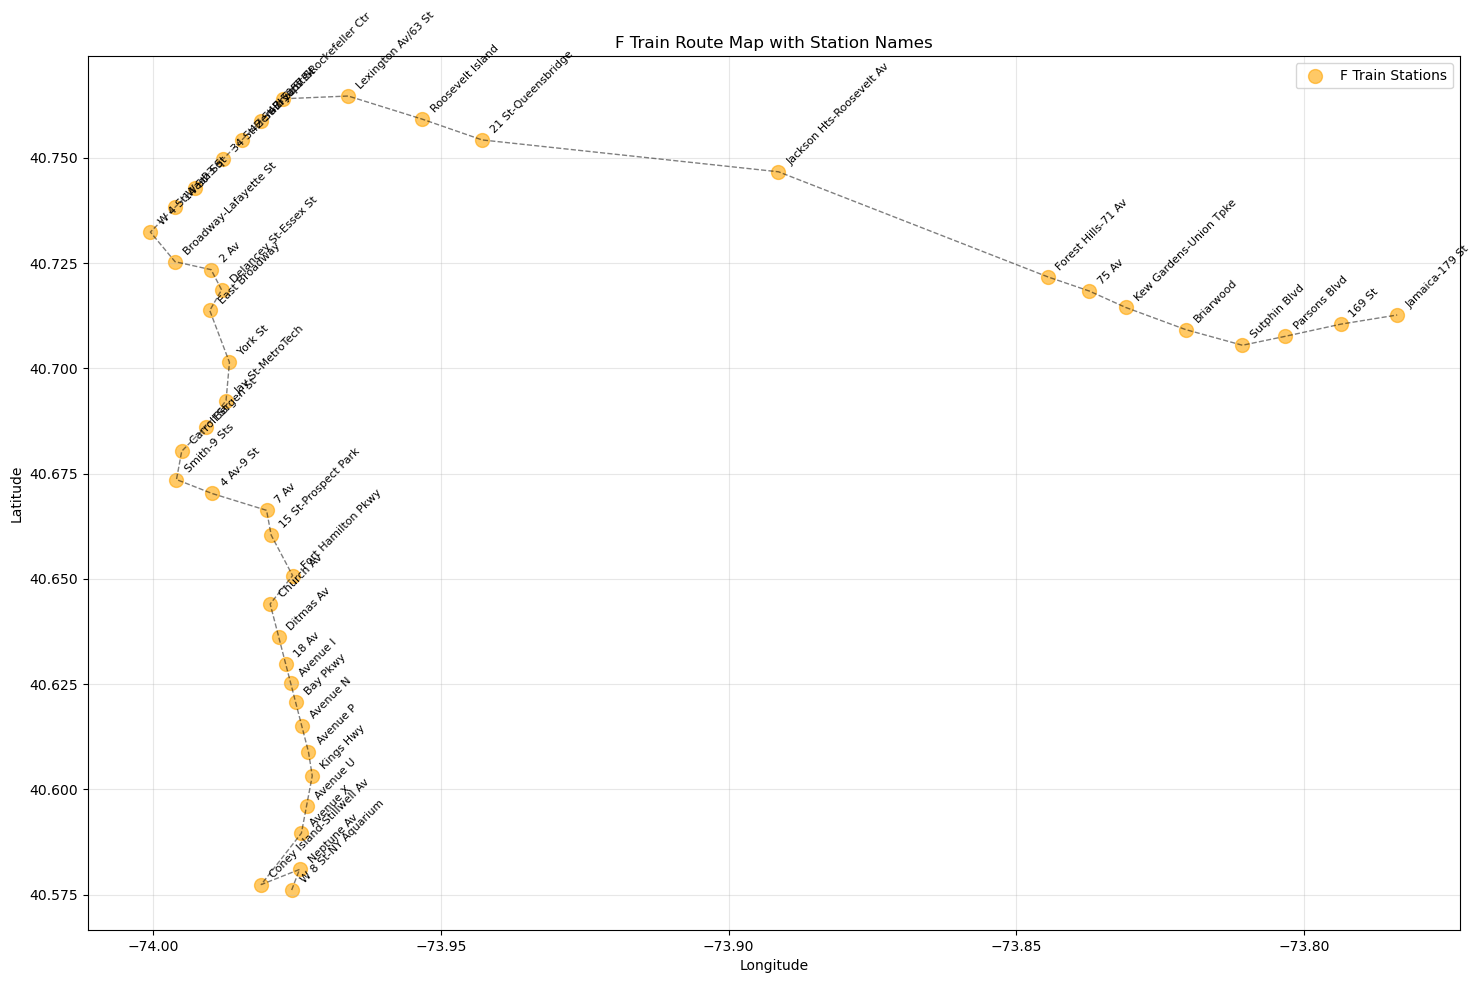

In [616]:
plt.figure(figsize=(15, 10))

# Plot all stations in orange
plt.scatter(
    f_train_ordered['GTFS Longitude'], 
    f_train_ordered['GTFS Latitude'],
    color='orange',  # Set color to orange
    alpha=0.6,
    s=100,
    label='F Train Stations'
)
# Add station names
for idx, row in f_train_ordered.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)
plt.title('F Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Now that we did the F train, we want to find all the Unique train stations in the data set.

In [617]:
# Create a set to store unique train lines
unique_lines = set()

# Split each combination and add individual lines to the set
for routes in data['Daytime Routes'].str.split():
    unique_lines.update(routes)

# Convert to sorted list
unique_lines = sorted(list(unique_lines))
unique_lines.remove('F')


print("Unique train lines:")
print(unique_lines)

# Optional: Count how many stations each line appears in
line_counts = {}
for routes in data['Daytime Routes'].str.split():
    for line in routes:
        line_counts[line] = line_counts.get(line, 0) + 1
"""
print("\nNumber of stations per line:")
for line in sorted(line_counts.keys()):
    print(f"Line {line}: {line_counts[line]} stations")
"""

Unique train lines:
['1', '2', '3', '4', '5', '6', '7', 'A', 'B', 'C', 'D', 'E', 'G', 'J', 'L', 'M', 'N', 'Q', 'R', 'S', 'SIR', 'W', 'Z']


'\nprint("\nNumber of stations per line:")\nfor line in sorted(line_counts.keys()):\n    print(f"Line {line}: {line_counts[line]} stations")\n'

Lets store each line as their own data frame, and save it under "train_lines" which is stored as a dictionary.

In [618]:
# Create a dictionary to store DataFrames for each line
train_lines = {}

# Create DataFrame for each line
for line in unique_lines:
    # Filter data for current line
    line_data = data[data['Daytime Routes'].str.contains(line)]
    coords = line_data[['GTFS Latitude', 'GTFS Longitude']].values
    
    # Calculate pairwise distances between all stations
    distances = pdist(coords)
    distance_matrix = squareform(distances)
    path = nearest_neighbor_path(distance_matrix)
    
    # Reorder the DataFrame using the path and reset the index
    line_data = line_data.iloc[path].reset_index(drop=True)
    
    # Store in dictionary
    train_lines[line] = line_data

#train_lines['R'] = train_lines['R'].drop(train_lines['R'].index[45:])

# Verify the ordering for a specific line
# print(train_lines['A'][['Stop Name', 'Borough', 'GTFS Latitude', 'GTFS Longitude']].head())

We will separate the code for each train line.

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


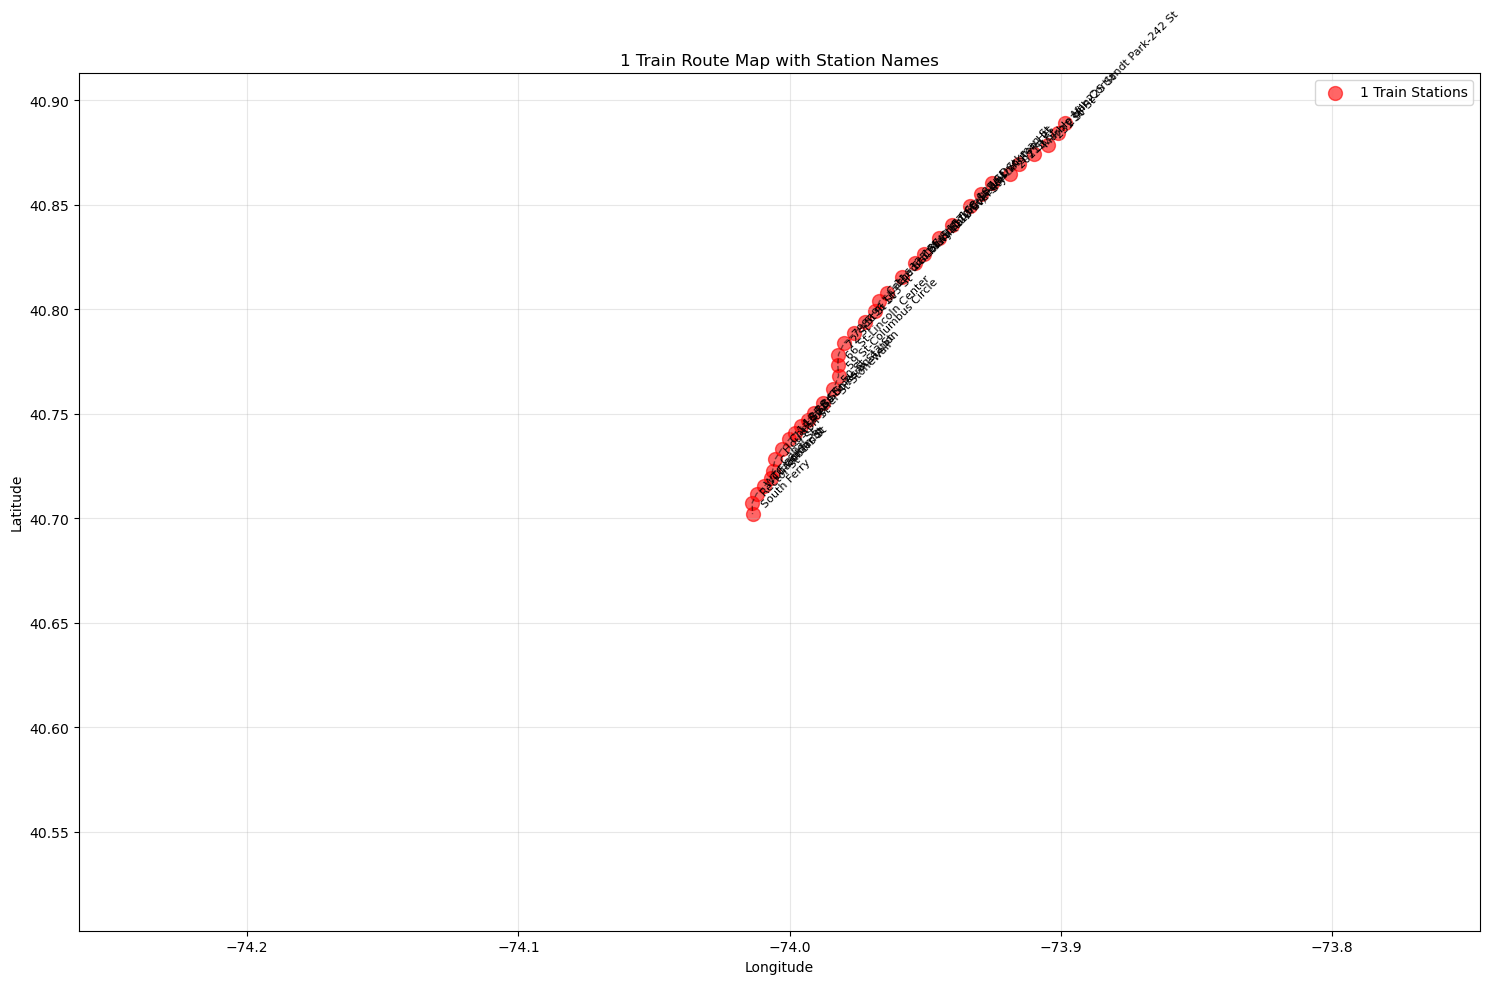

In [619]:
# First, find the overall bounds for all stations
all_lats = data['GTFS Latitude'].values
all_lons = data['GTFS Longitude'].values

# Calculate the bounds with a small padding
lat_min, lat_max = all_lats.min() - 0.01, all_lats.max() + 0.01
lon_min, lon_max = all_lons.min() - 0.01, all_lons.max() + 0.01

curr_line = unique_lines[0]


plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='red',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Q A G 

[48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


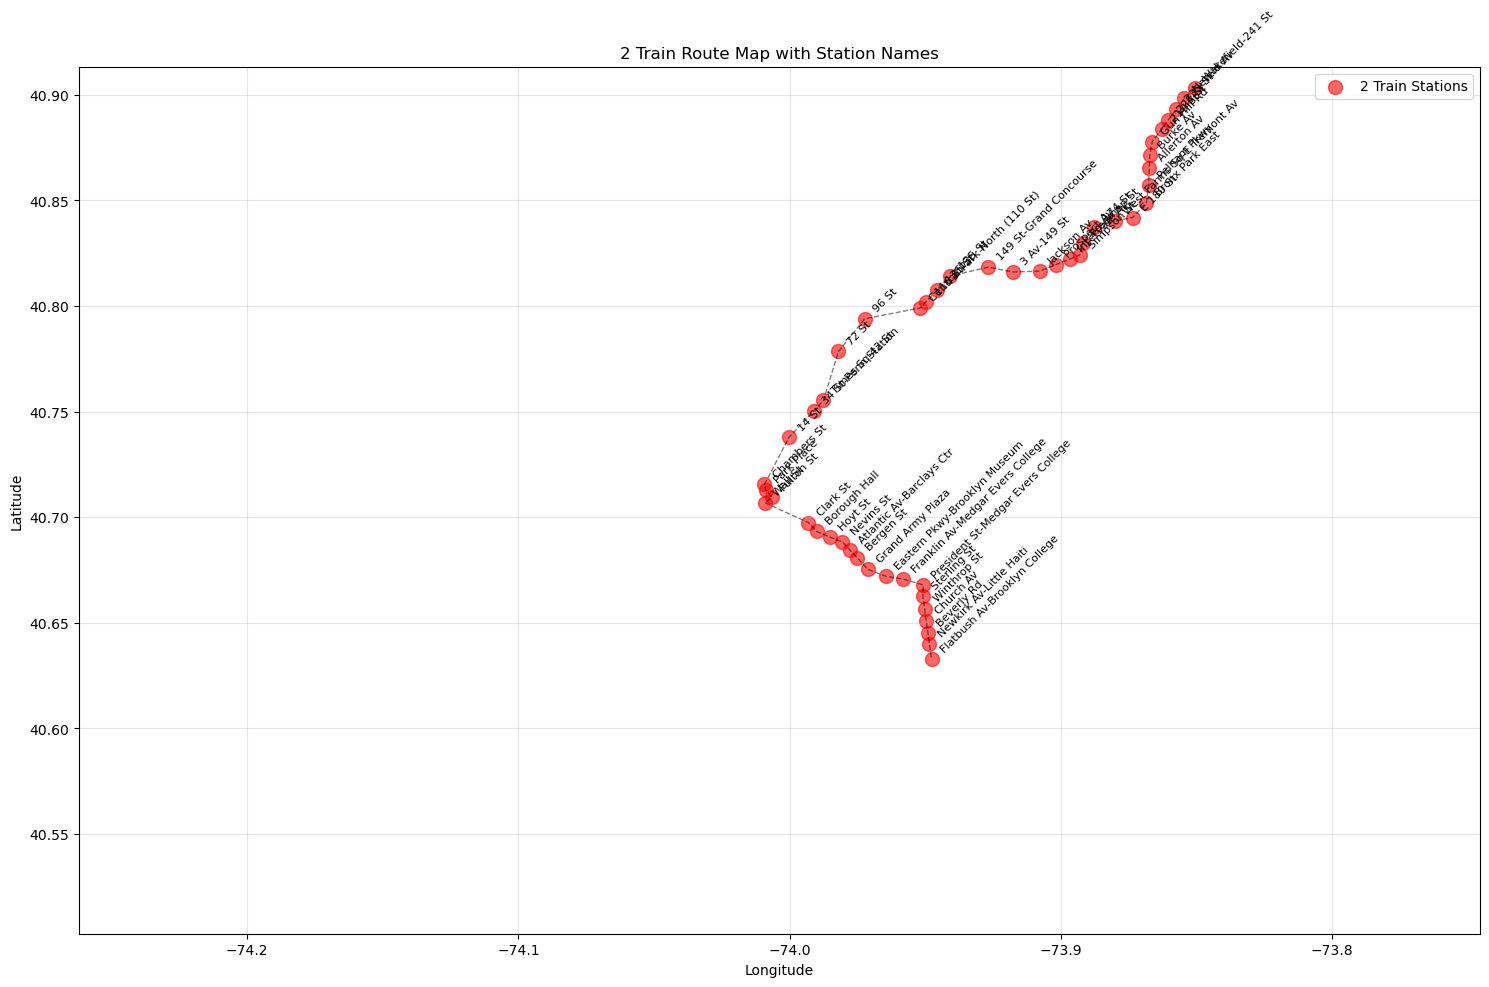

In [620]:
curr_line = unique_lines[1]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='red',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 48)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Q A G 

In [621]:
pd.set_option('display.max_rows', None)
train_lines[unique_lines[18]]


,GTFS Stop ID,Station ID,Complex ID,Division,Line,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
0,R11,7,613,BMT,Astoria,Lexington Av/59 St,M,True,N R W,Subway,40.762660,-73.967258,Queens,Downtown,0,0,0,NaN,POINT (-73.967258 40.76266)
1,R13,8,8,BMT,Astoria,5 Av/59 St,M,True,N R W,Subway,40.764811,-73.973347,Queens,Downtown,0,0,0,NaN,POINT (-73.973347 40.764811)
2,R14,9,9,BMT,Broadway - Brighton,57 St-7 Av,M,True,N Q R W,Subway,40.764664,-73.980658,Uptown,Downtown,1,1,1,NaN,POINT (-73.980658 40.764664)
3,R15,10,10,BMT,Broadway - Brighton,49 St,M,True,N R W,Subway,40.759901,-73.984139,Uptown,Downtown,2,1,0,Uptown only,POINT (-73.984139 40.759901)
4,R16,11,611,BMT,Broadway - Brighton,Times Sq-42 St,M,True,N Q R W,Subway,40.754672,-73.986754,Uptown,Downtown,1,1,1,NaN,POINT (-73.986754 40.754672)
5,R17,12,607,BMT,Broadway - Brighton,34 St-Herald Sq,M,True,N Q R W,Subway,40.749567,-73.987950,Uptown,Downtown,1,1,1,NaN,POINT (-73.98795 40.749567)
6,R18,13,13,BMT,Broadway - Brighton,28 St,M,True,R W,Subway,40.745494,-73.988691,Uptown,Downtown,0,0,0,NaN,POINT (-73.988691 40.745494)
7,R19,14,14,BMT,Broadway - Brighton,23 St,M,True,R W,Subway,40.741303,-73.989344,Uptown,Downtown,0,0,0,NaN,POINT (-73.989344 40.741303)
8,R20,15,602,BMT,Broadway - Brighton,14 St-Union Sq,M,True,N Q R W,Subway,40.735736,-73.990568,Uptown,Downtown,1,1,1,NaN,POINT (-73.990568 40.735736)
9,R21,16,16,BMT,Broadway - Brighton,8 St-NYU,M,True,R W,Subway,40.730328,-73.992629,Uptown,Downtown,0,0,0,NaN,POINT (-73.992629 40.730328)


[33, 32, 31, 30, 29, 28, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


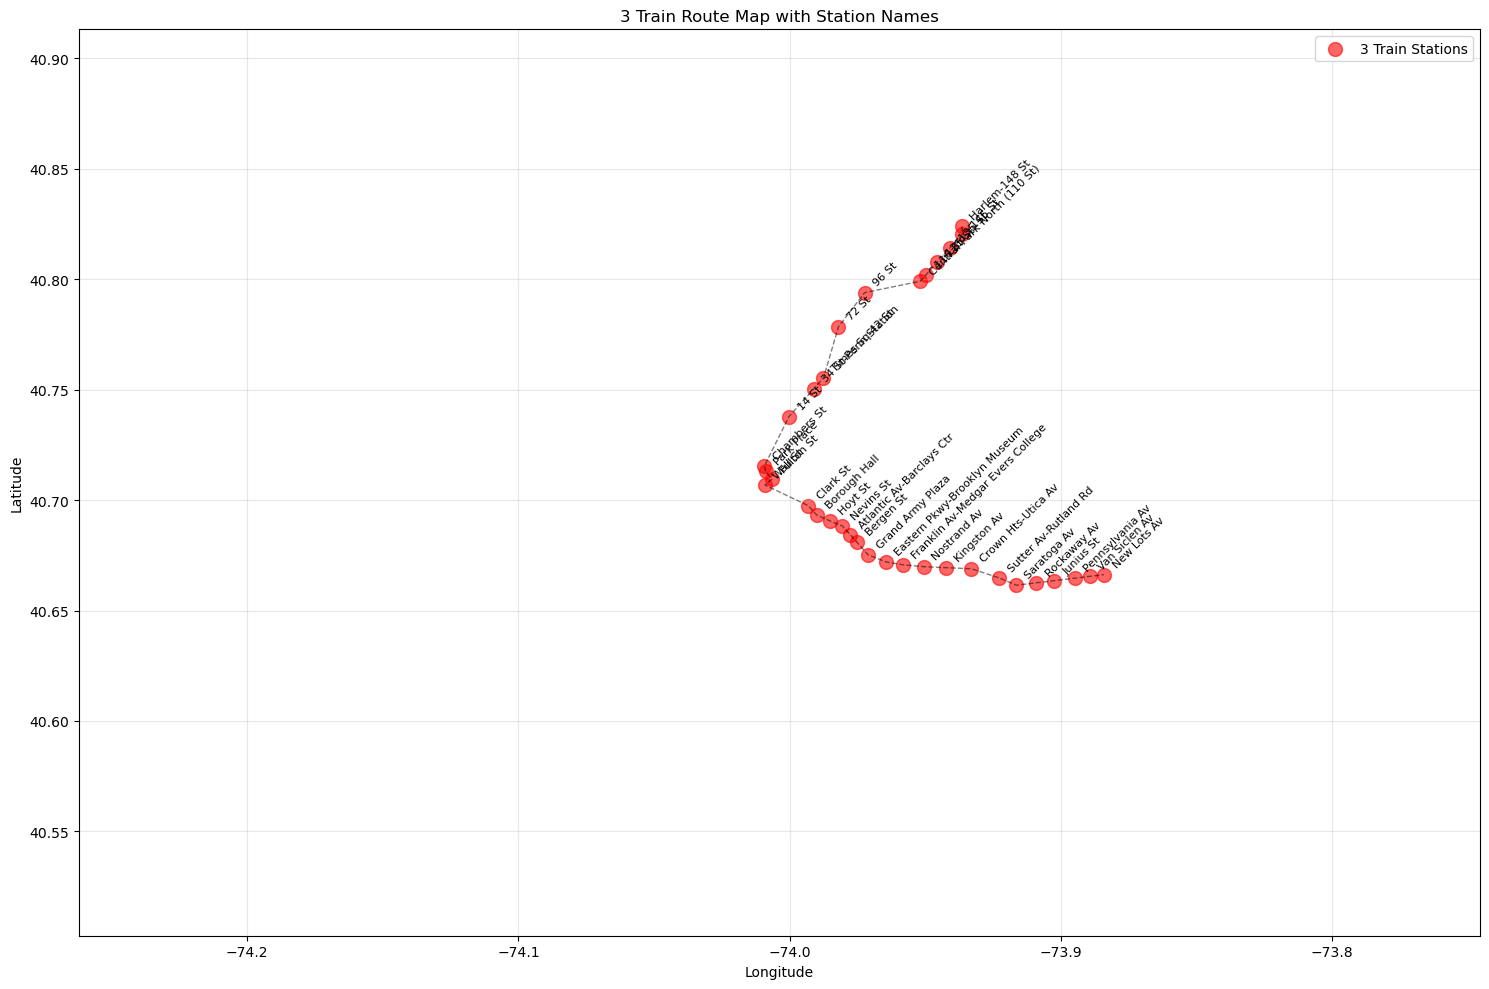

In [622]:
curr_line = unique_lines[2]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='red',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 33)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Q A G 

[25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 3, 4, 5, 6, 2, 0, 1, 27, 26]


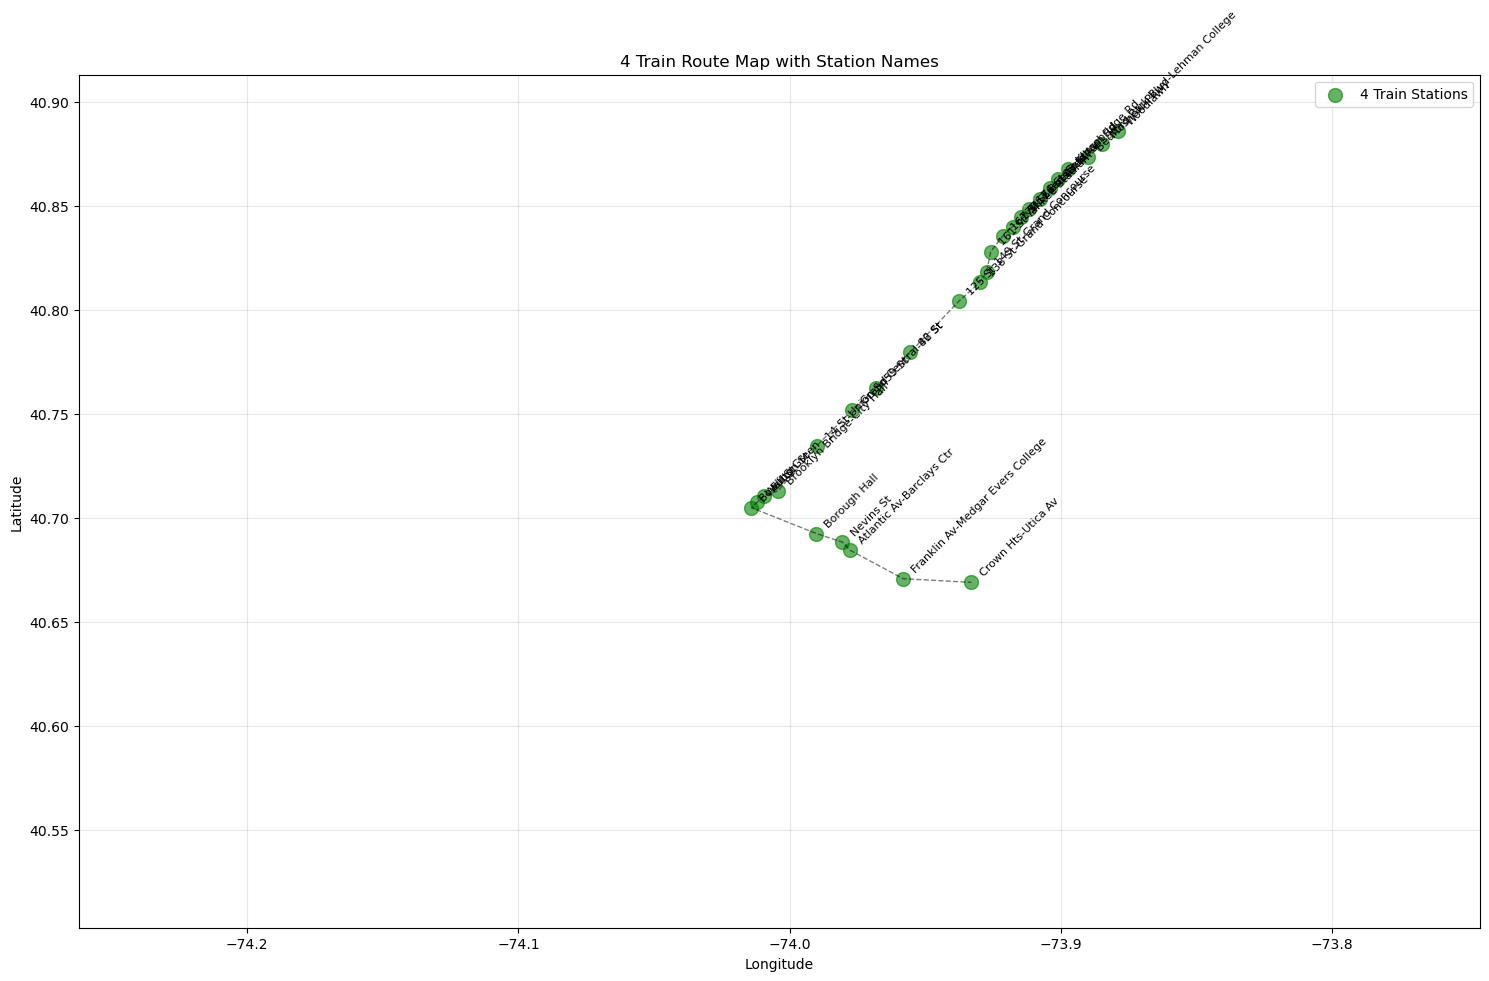

In [623]:
curr_line = unique_lines[3]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='green',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 25)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[25, 26, 24, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 3, 4, 5, 6, 2, 0, 1, 44, 37, 38, 39, 40, 41, 42, 43]


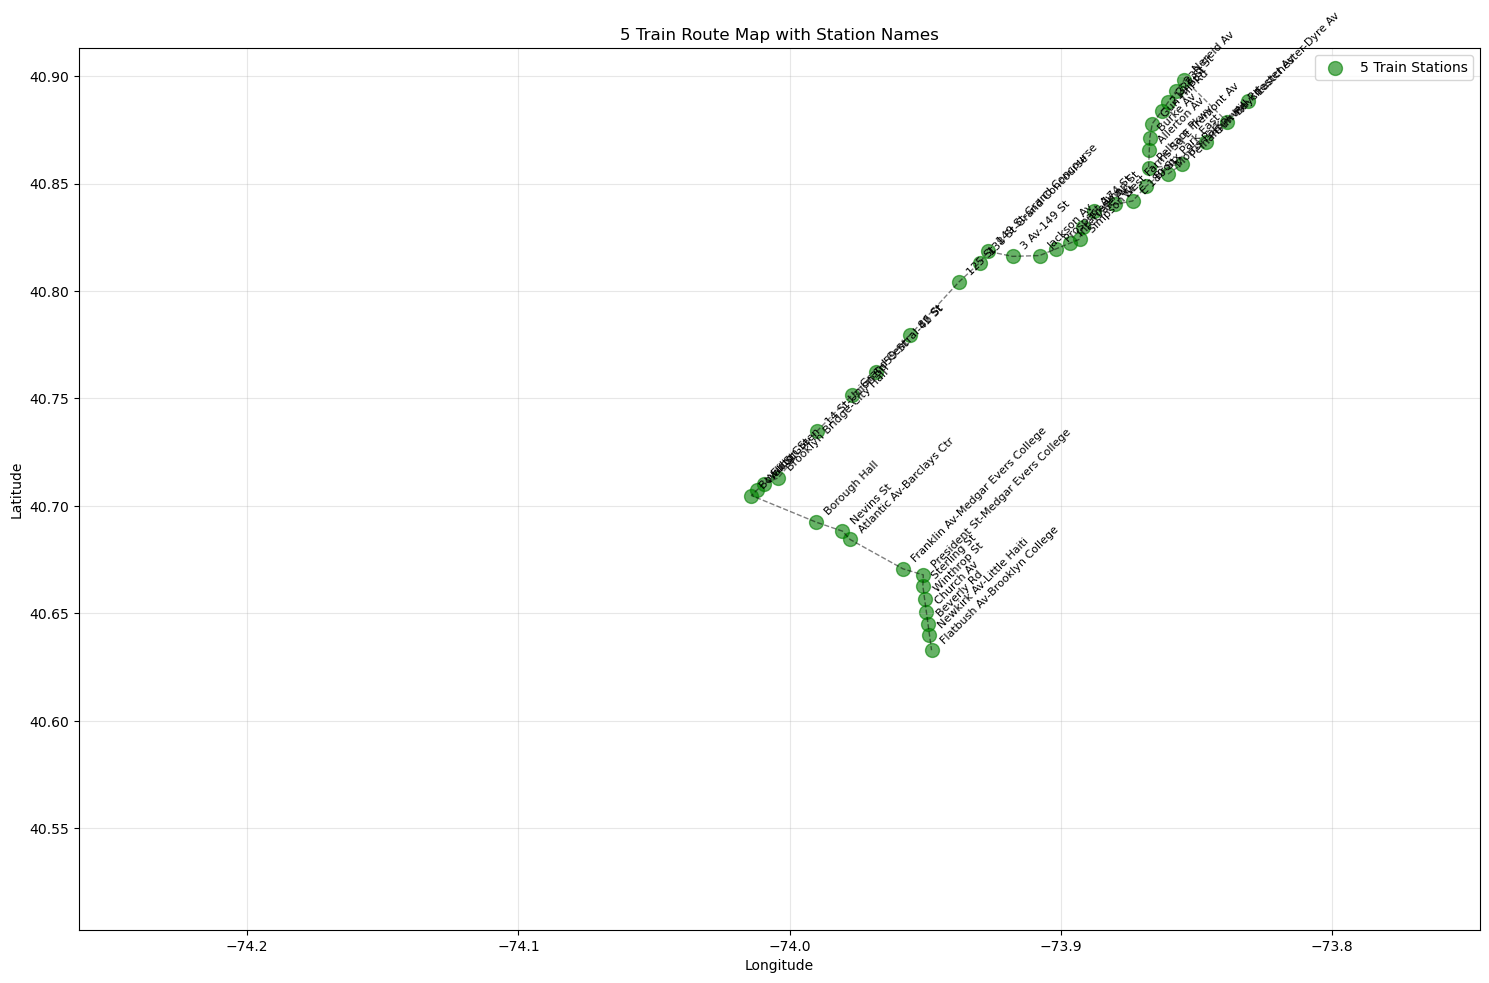

In [624]:
curr_line = unique_lines[4]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='green',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 25)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]


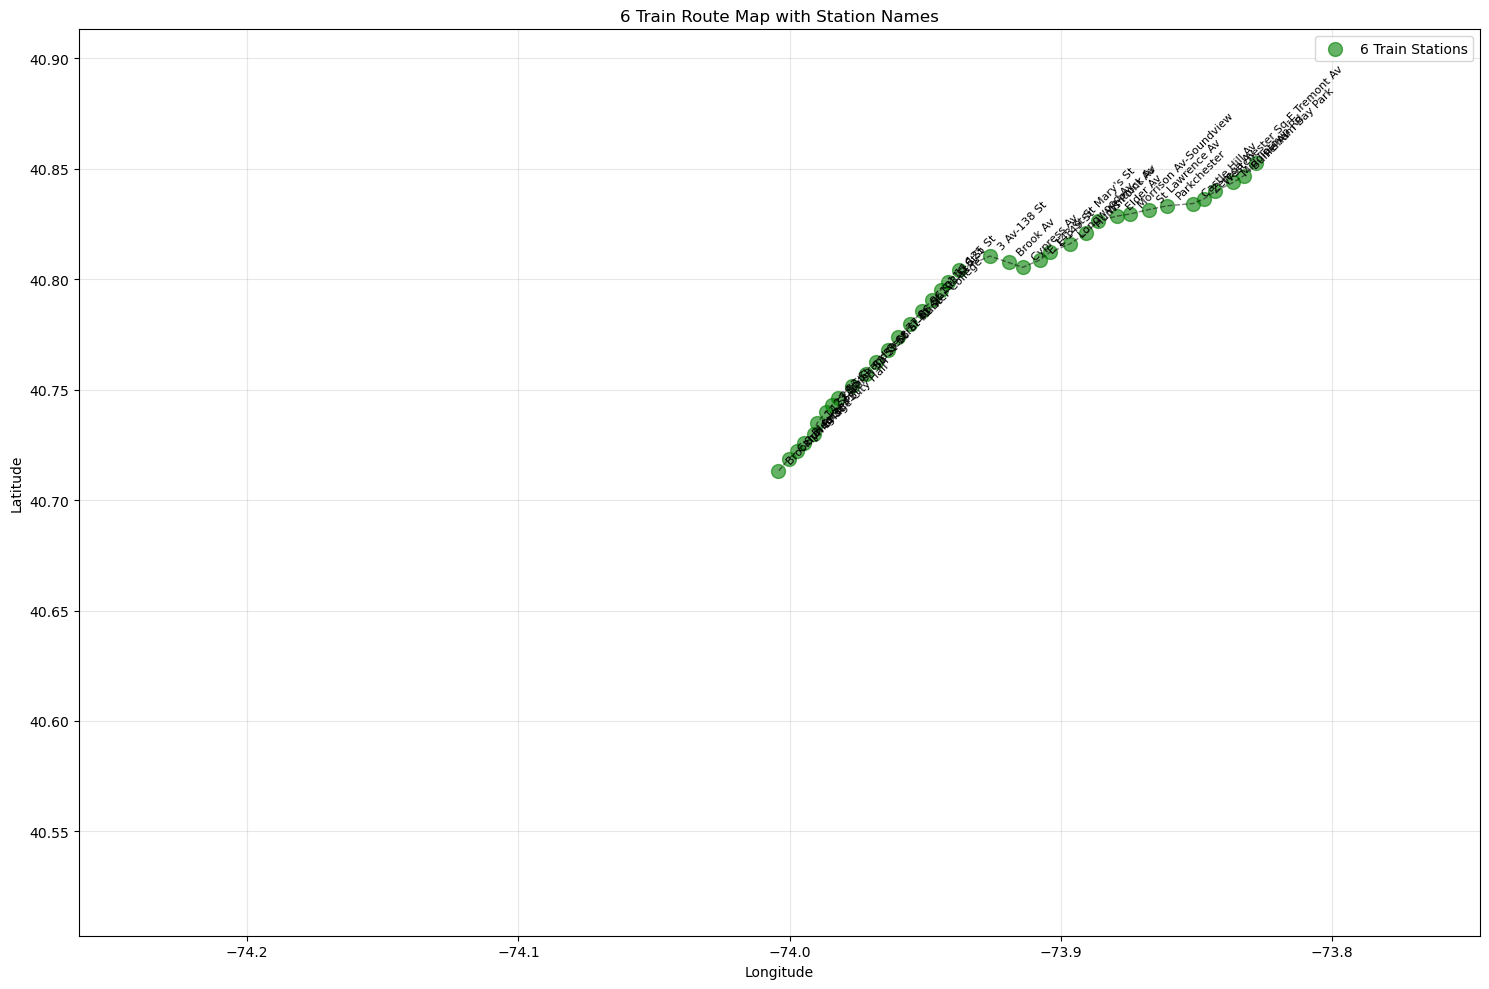

In [641]:
curr_line = unique_lines[5]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='green',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 25)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


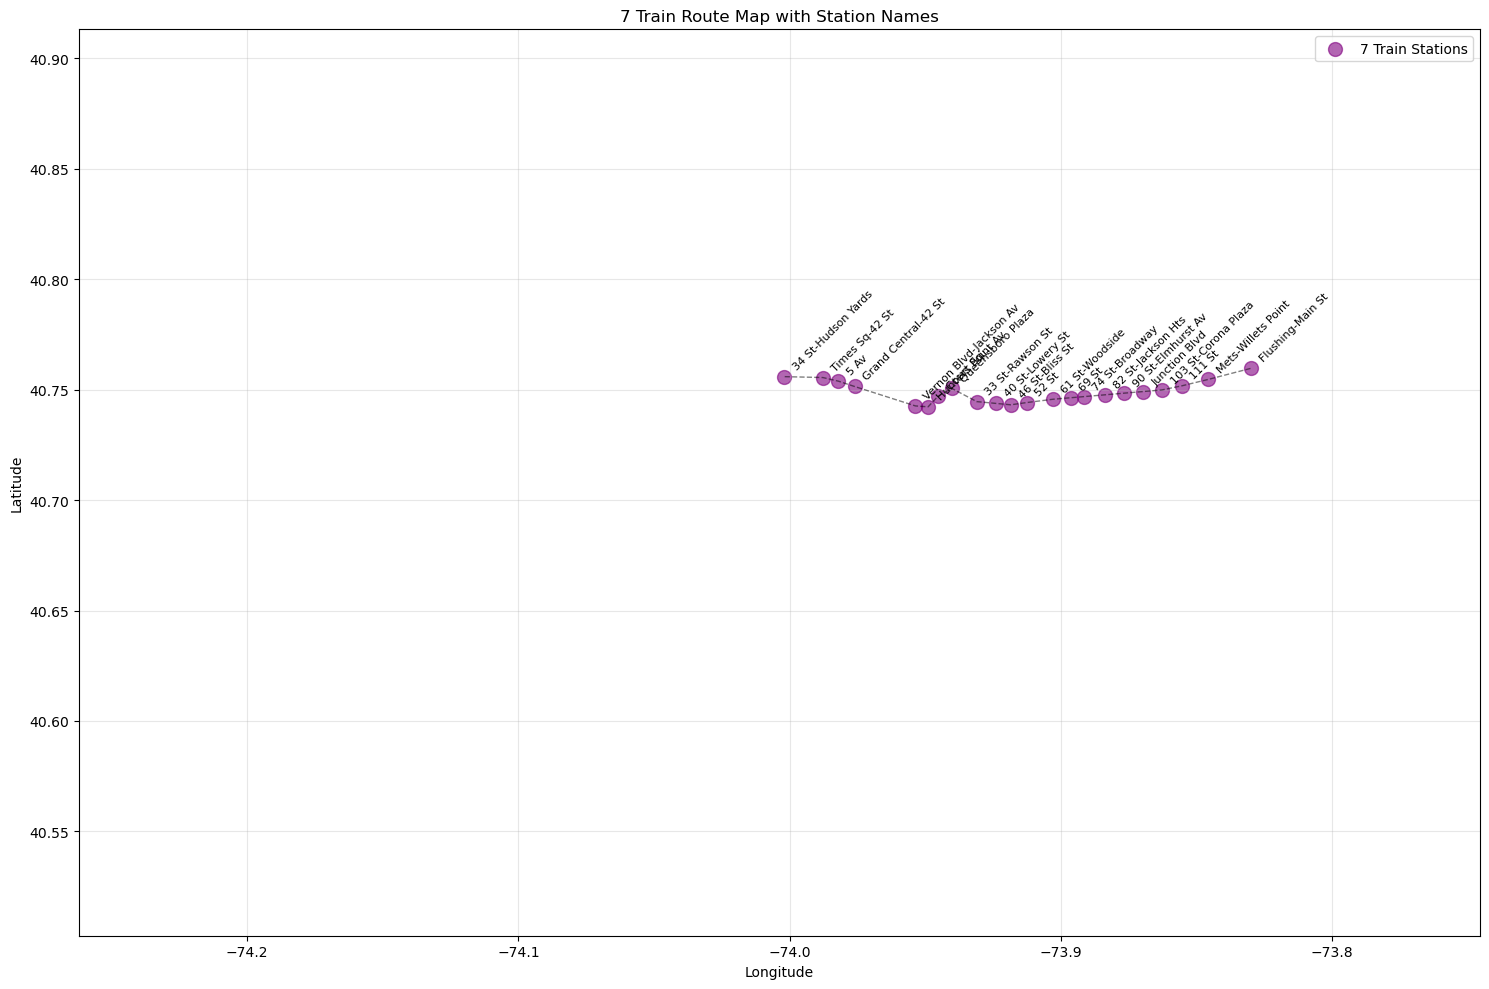

In [626]:
curr_line = unique_lines[6]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='purple',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[43, 42, 41, 40, 39, 38, 34, 35, 36, 37, 33, 32, 31, 30, 27, 28, 29, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


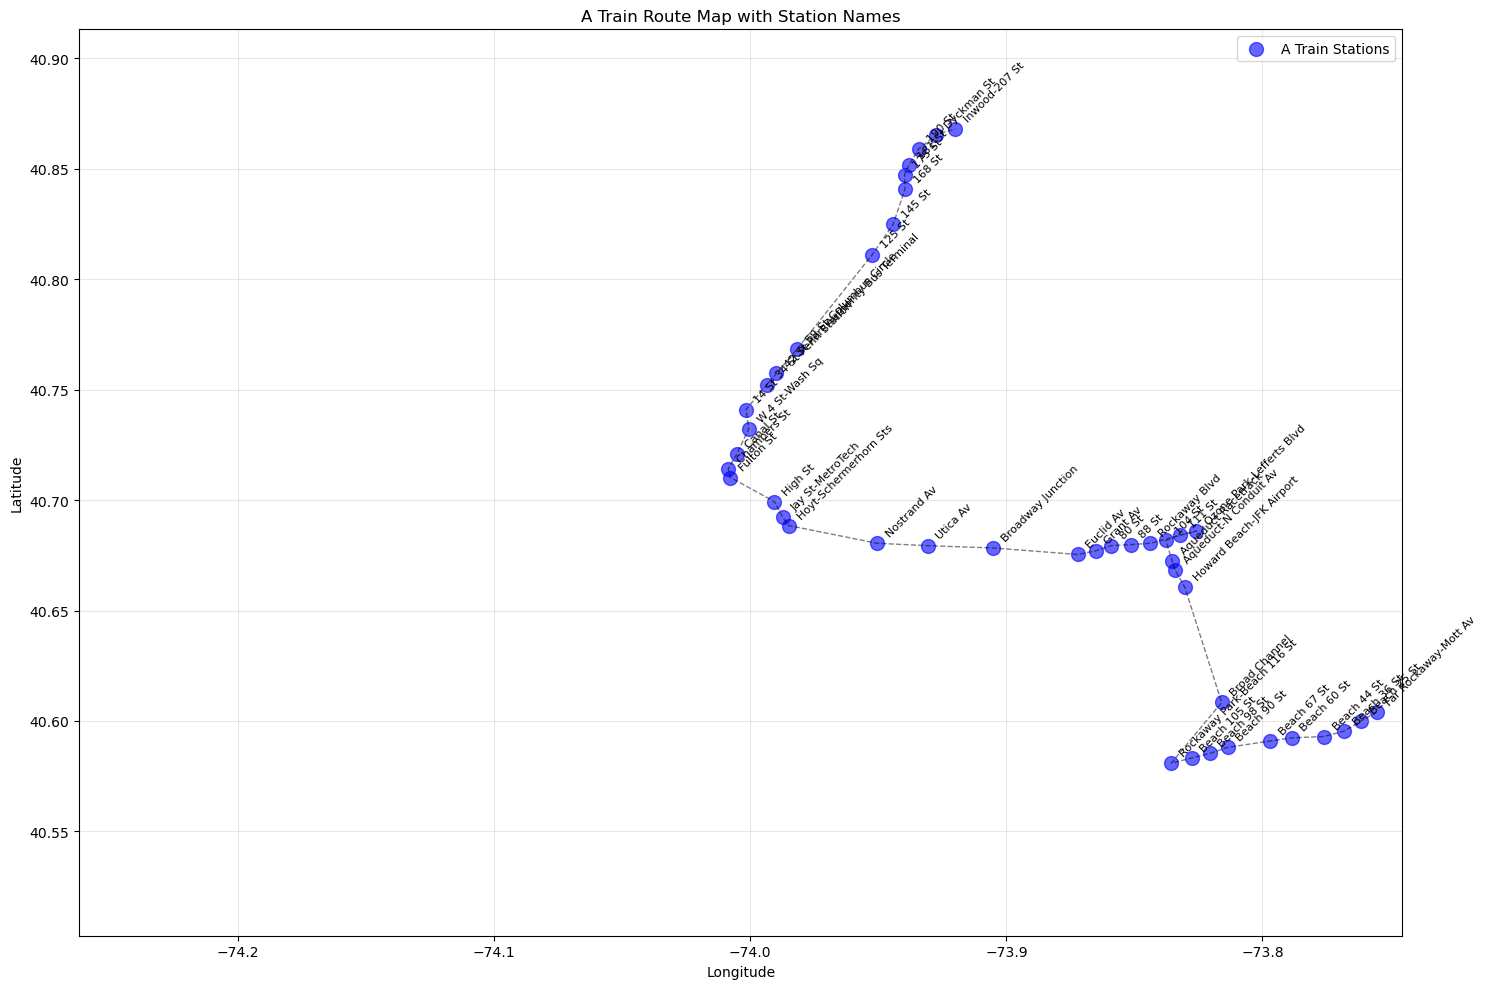

In [627]:
curr_line = unique_lines[7]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='blue',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 43)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


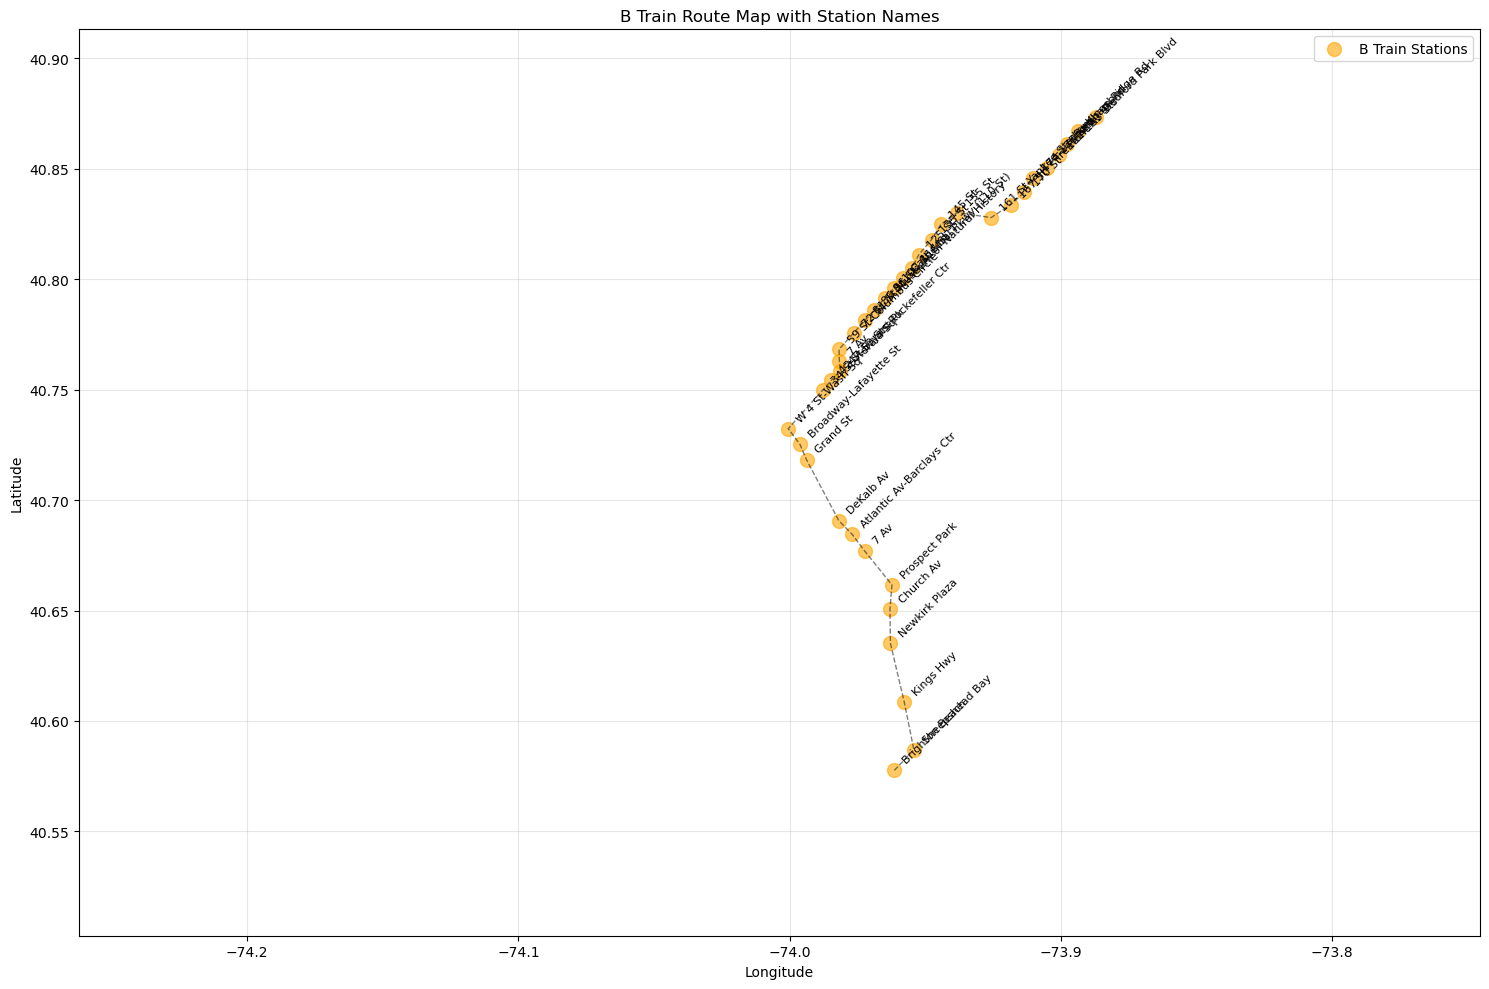

In [642]:
curr_line = unique_lines[8]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='orange',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 11)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


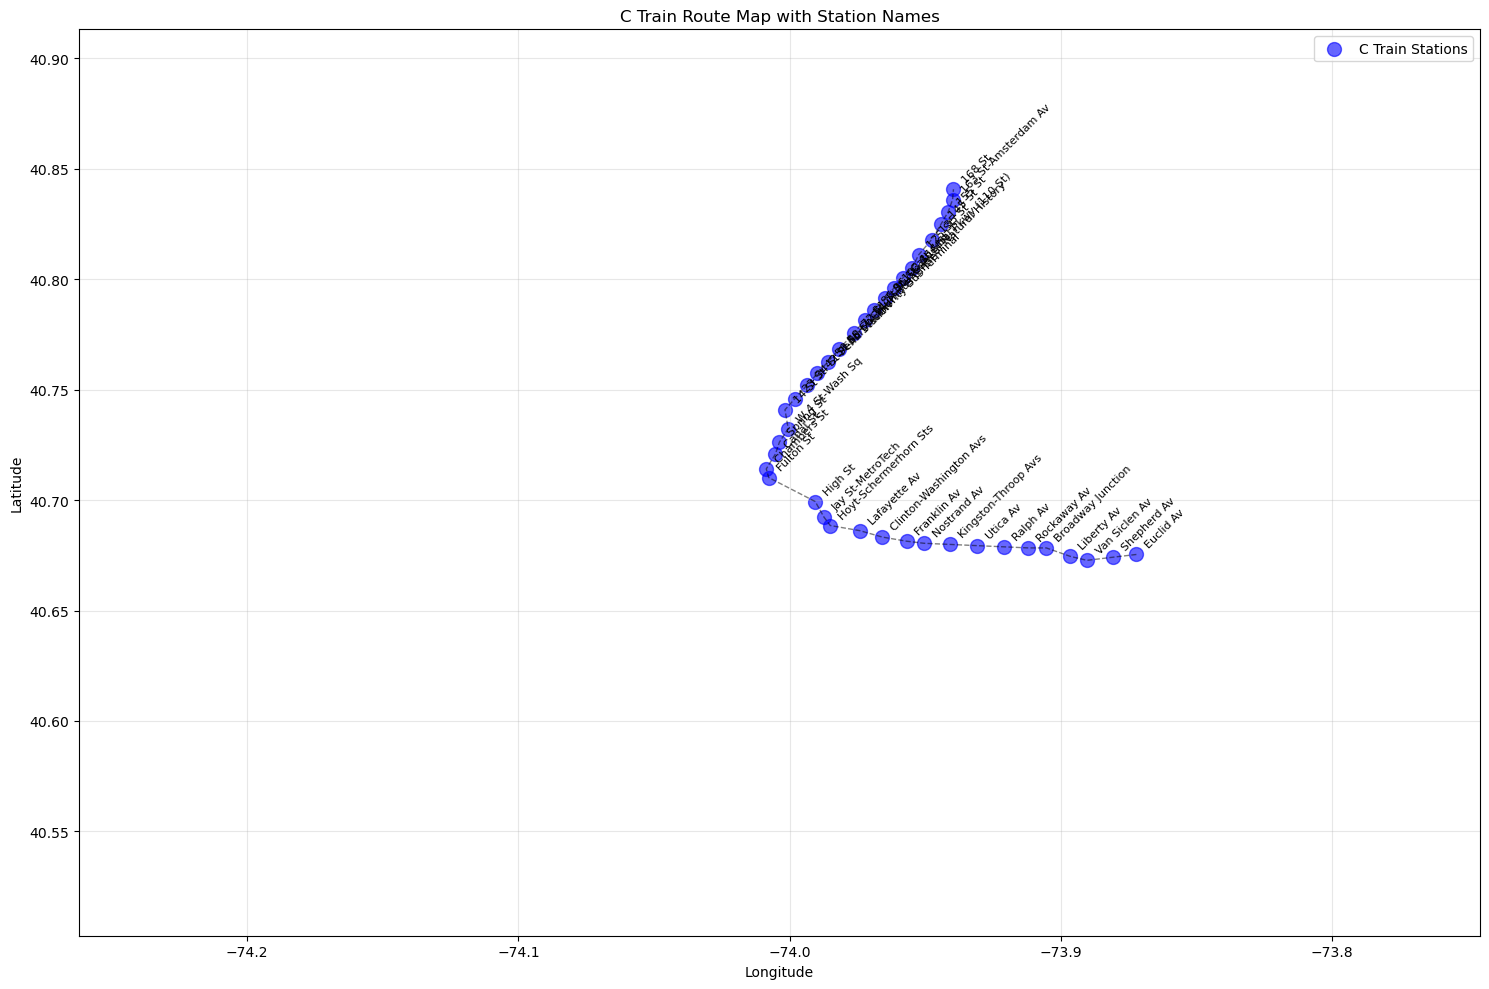

In [629]:
curr_line = unique_lines[9]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='blue',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 39)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


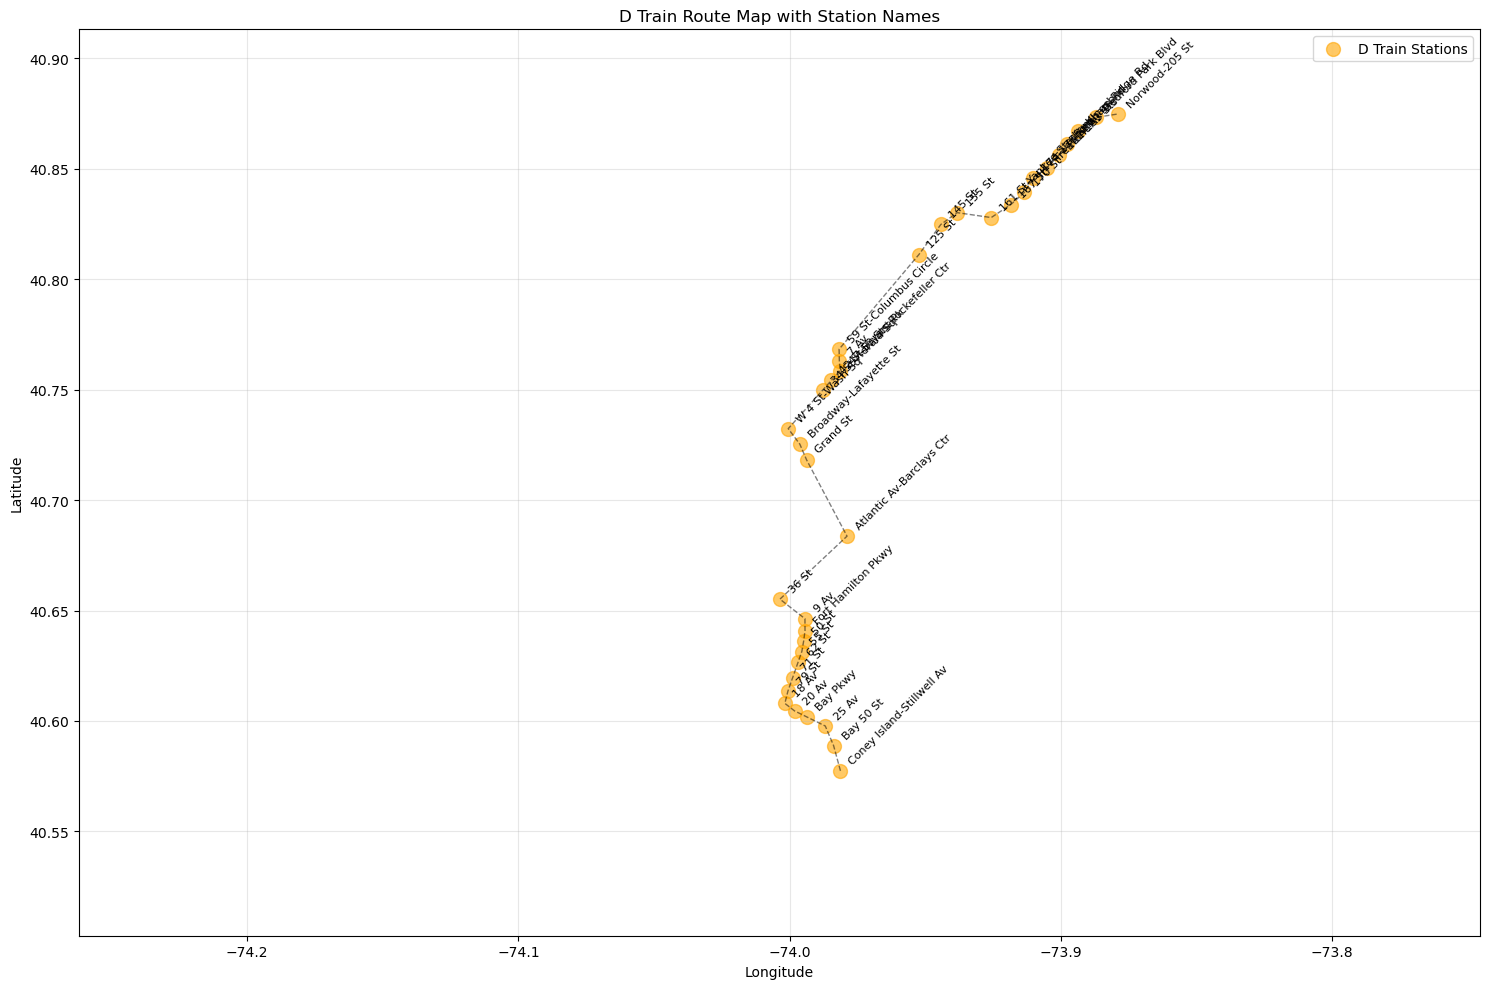

In [630]:
curr_line = unique_lines[10]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='orange',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 35)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 3, 2, 1, 0, 4, 5, 6, 7, 8, 9, 10, 11]


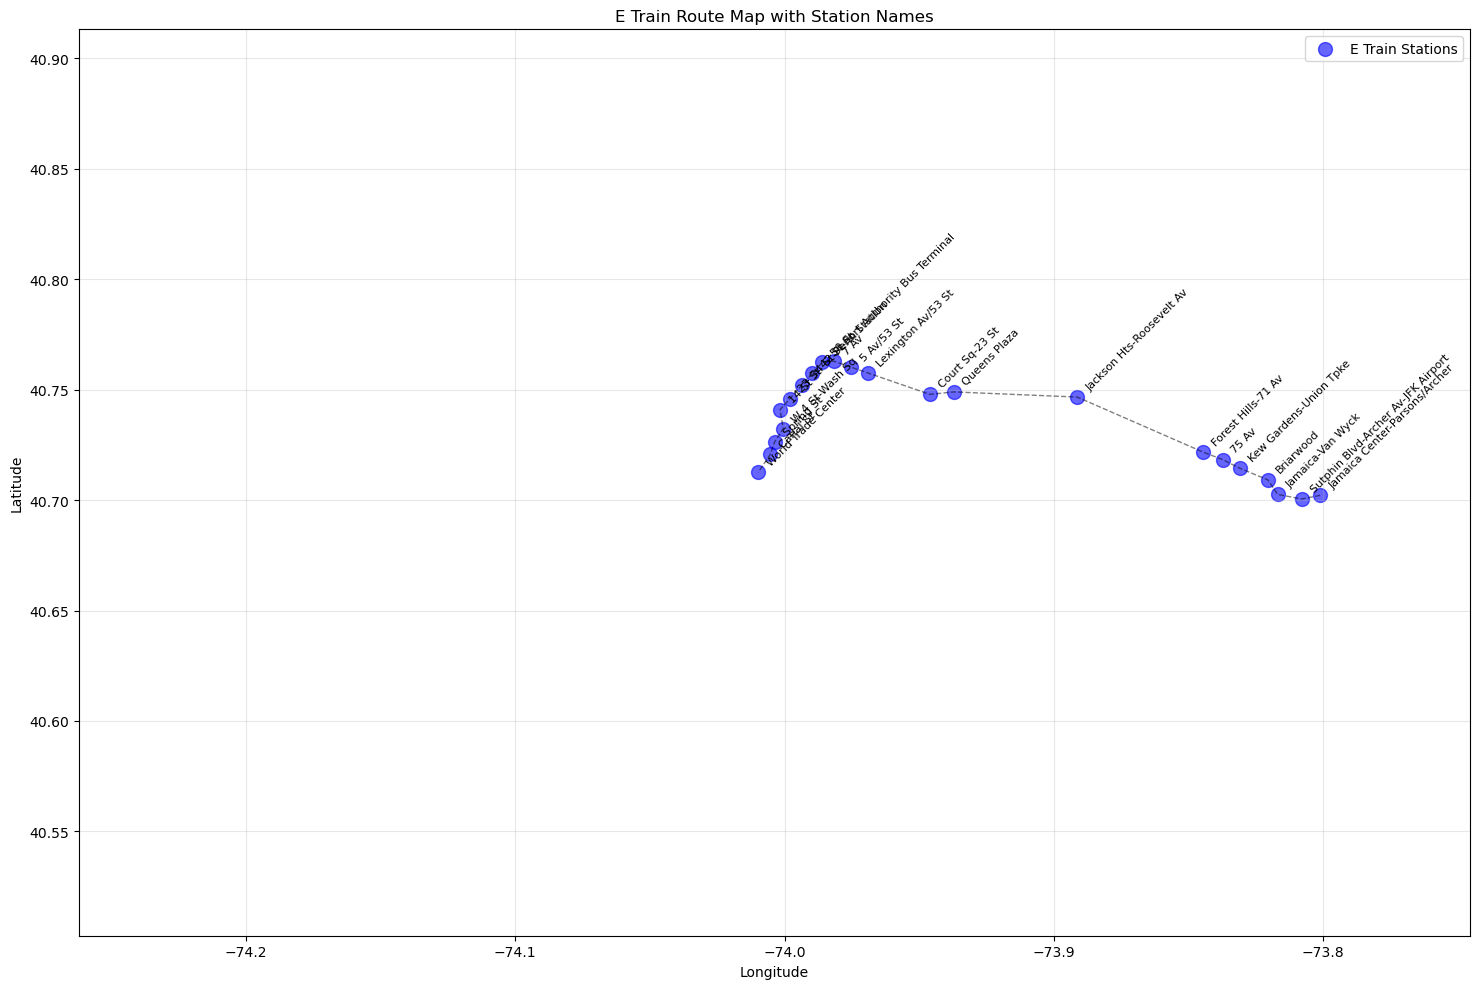

In [631]:
curr_line = unique_lines[11]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='blue',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 21)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8]


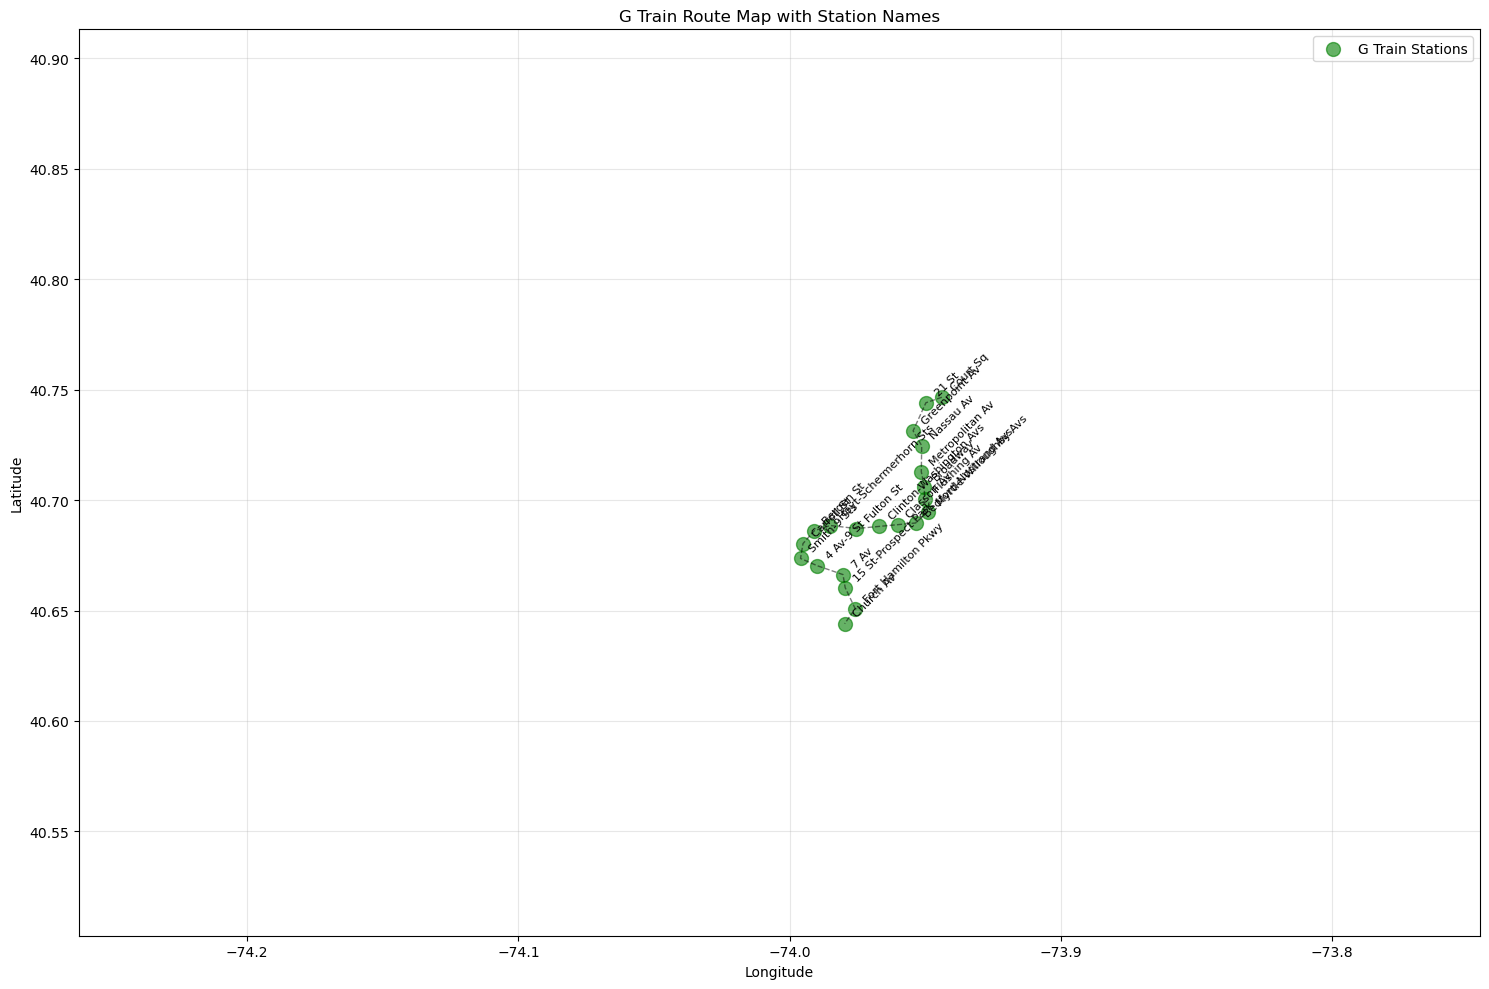

In [632]:
curr_line = unique_lines[12]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='green',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 20)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 28, 29]


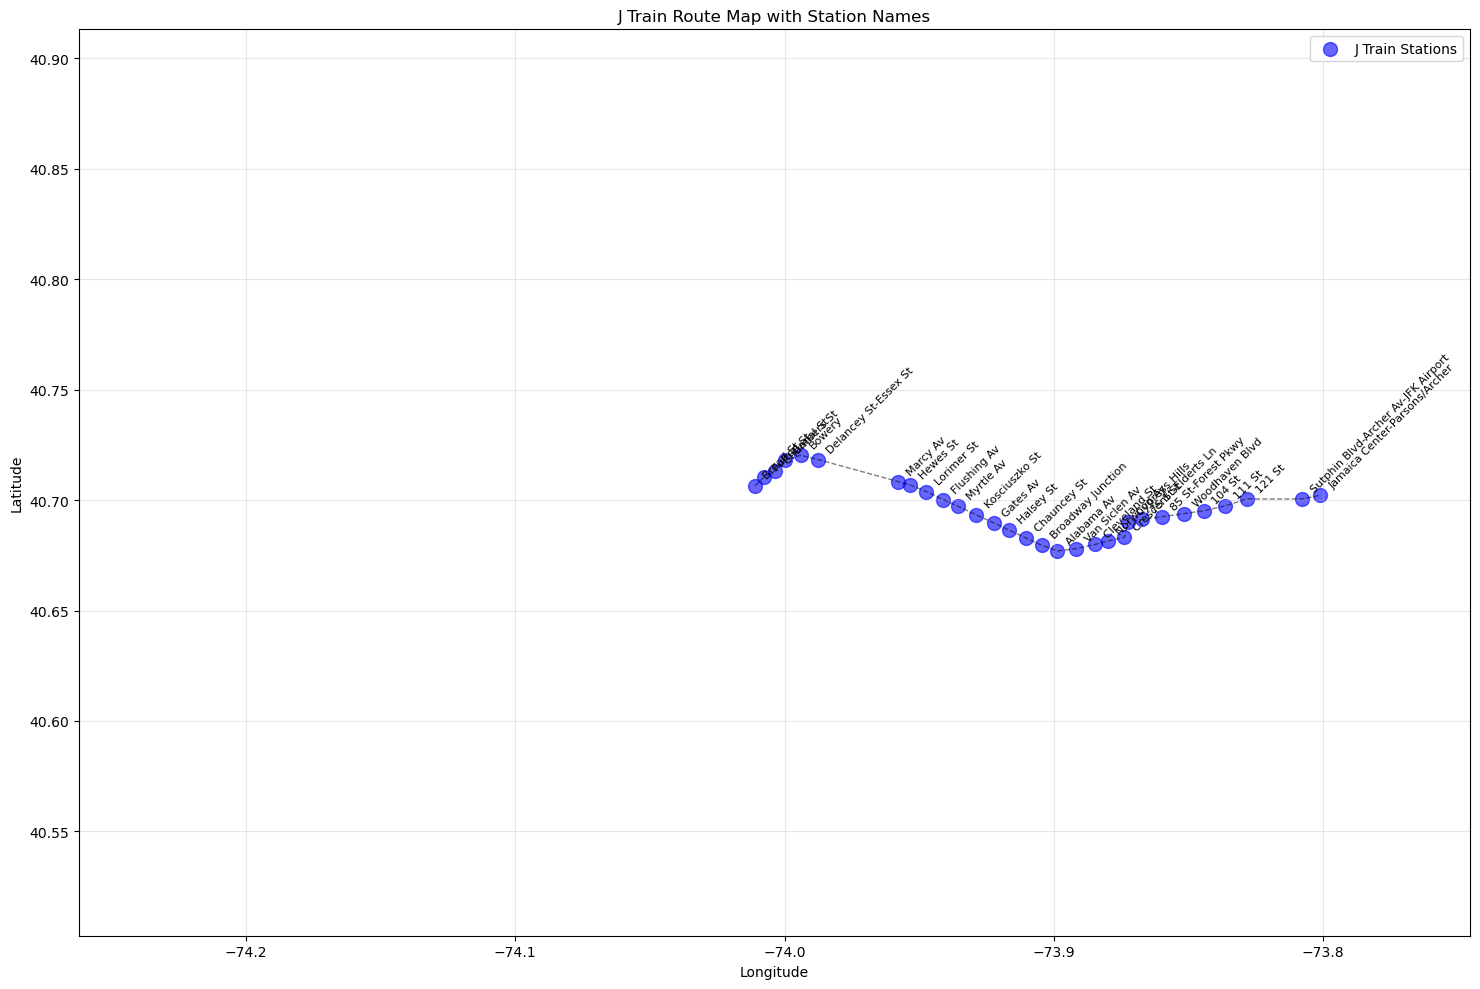

In [633]:
curr_line = unique_lines[13]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='blue',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 27)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]


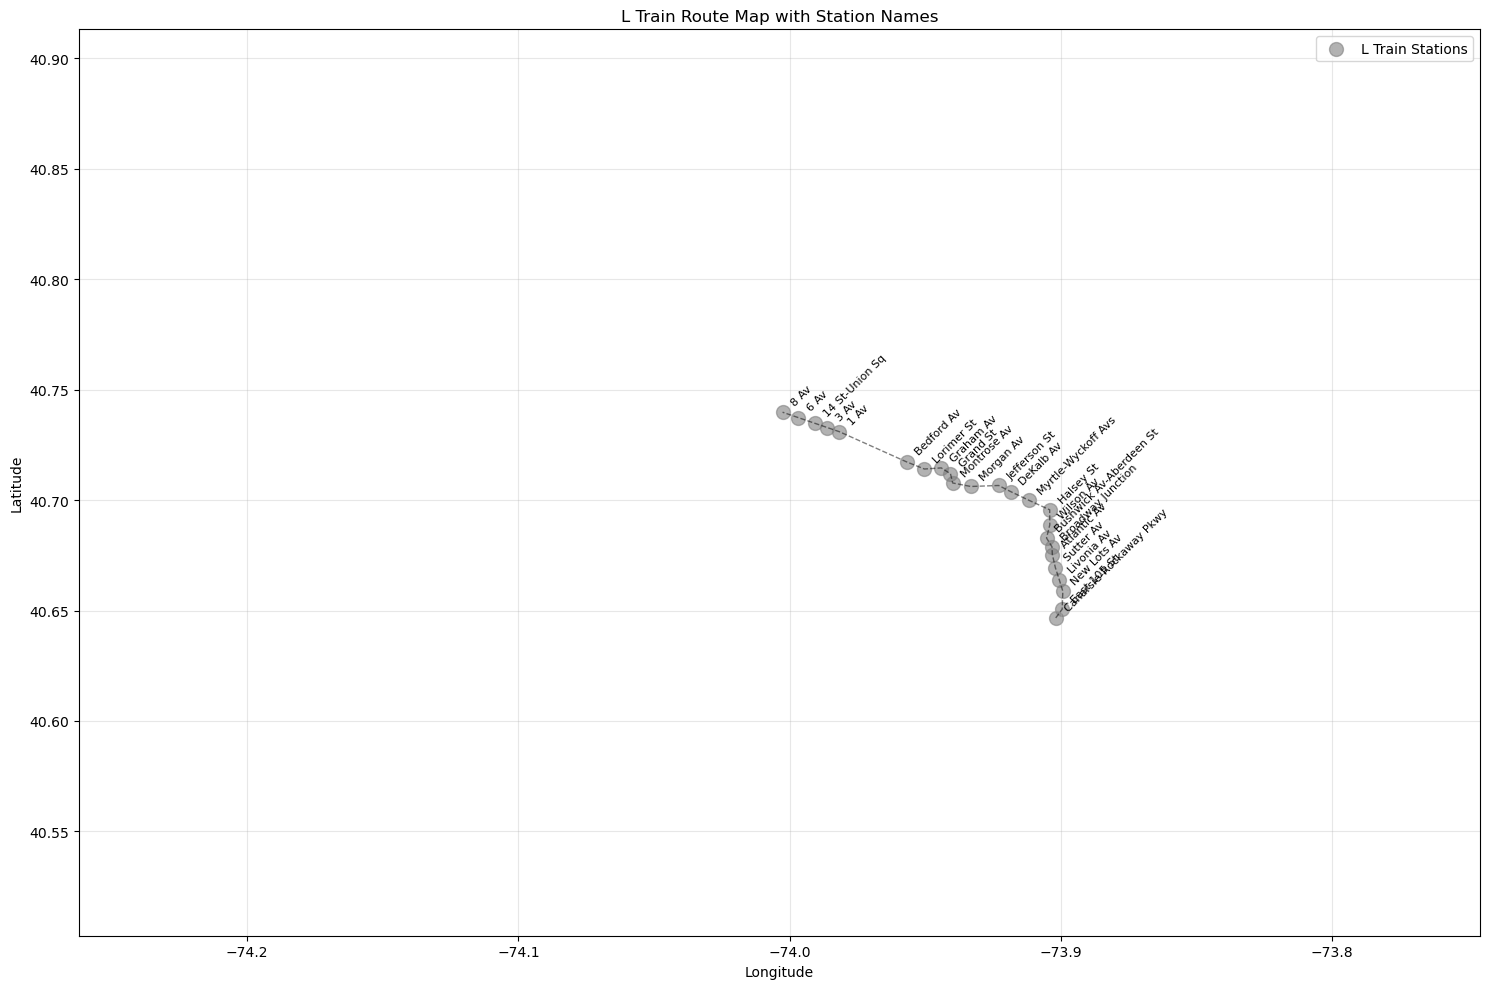

In [634]:
curr_line = unique_lines[14]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='grey',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 23)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, 35, 34, 33, 32, 31, 30, 29]


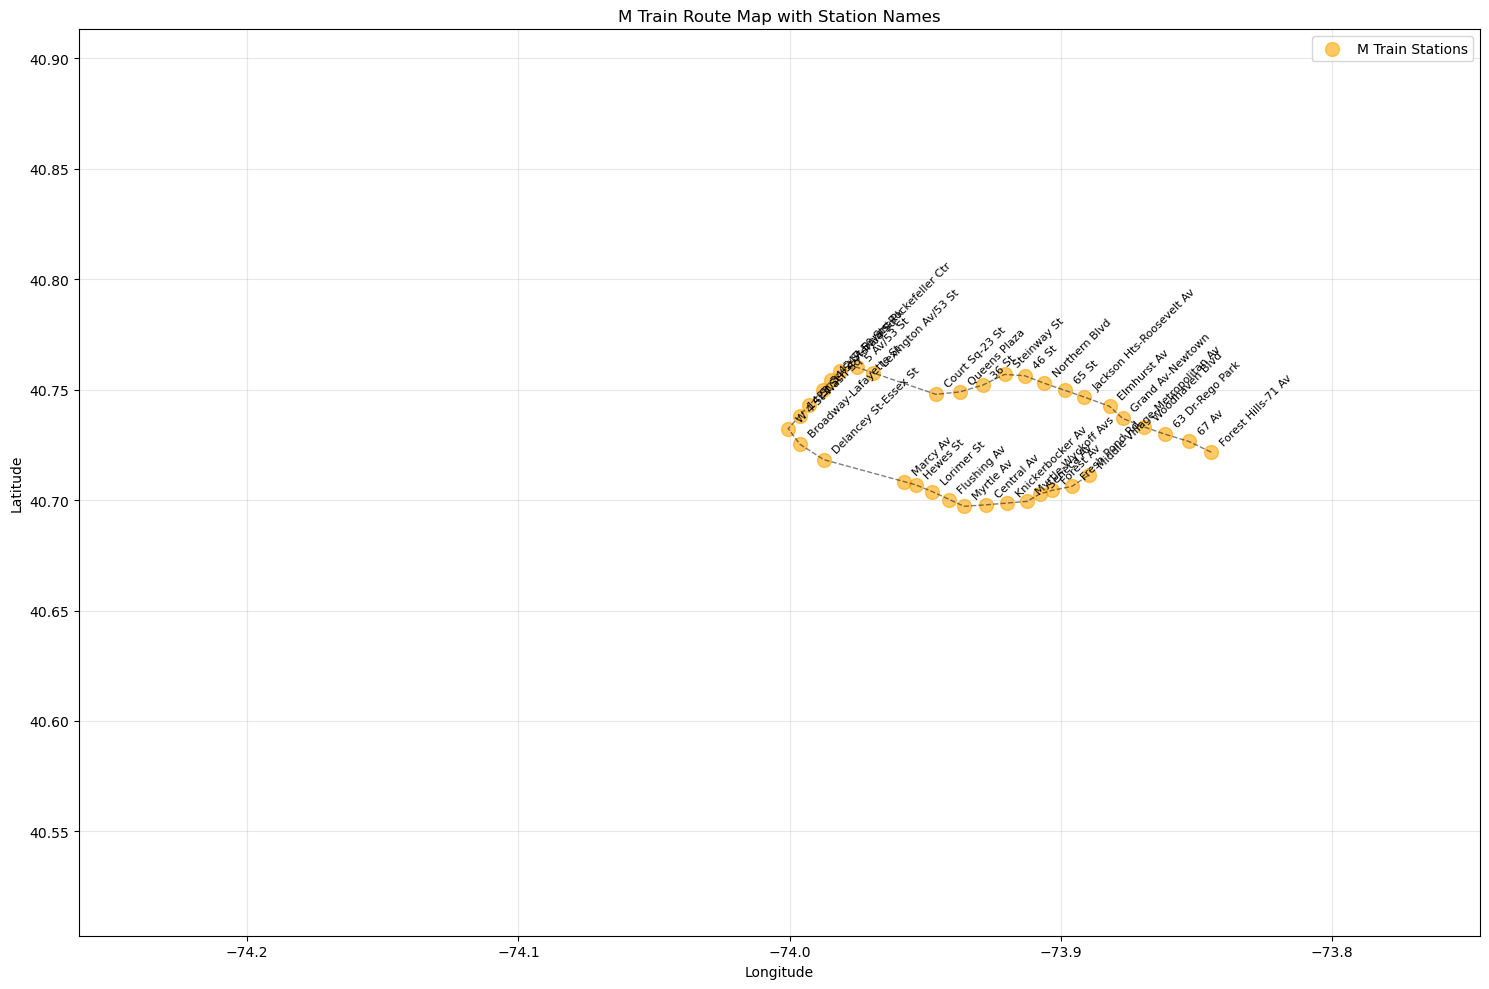

In [635]:
curr_line = unique_lines[15]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='orange',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 28)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[6, 5, 4, 3, 2, 1, 0, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


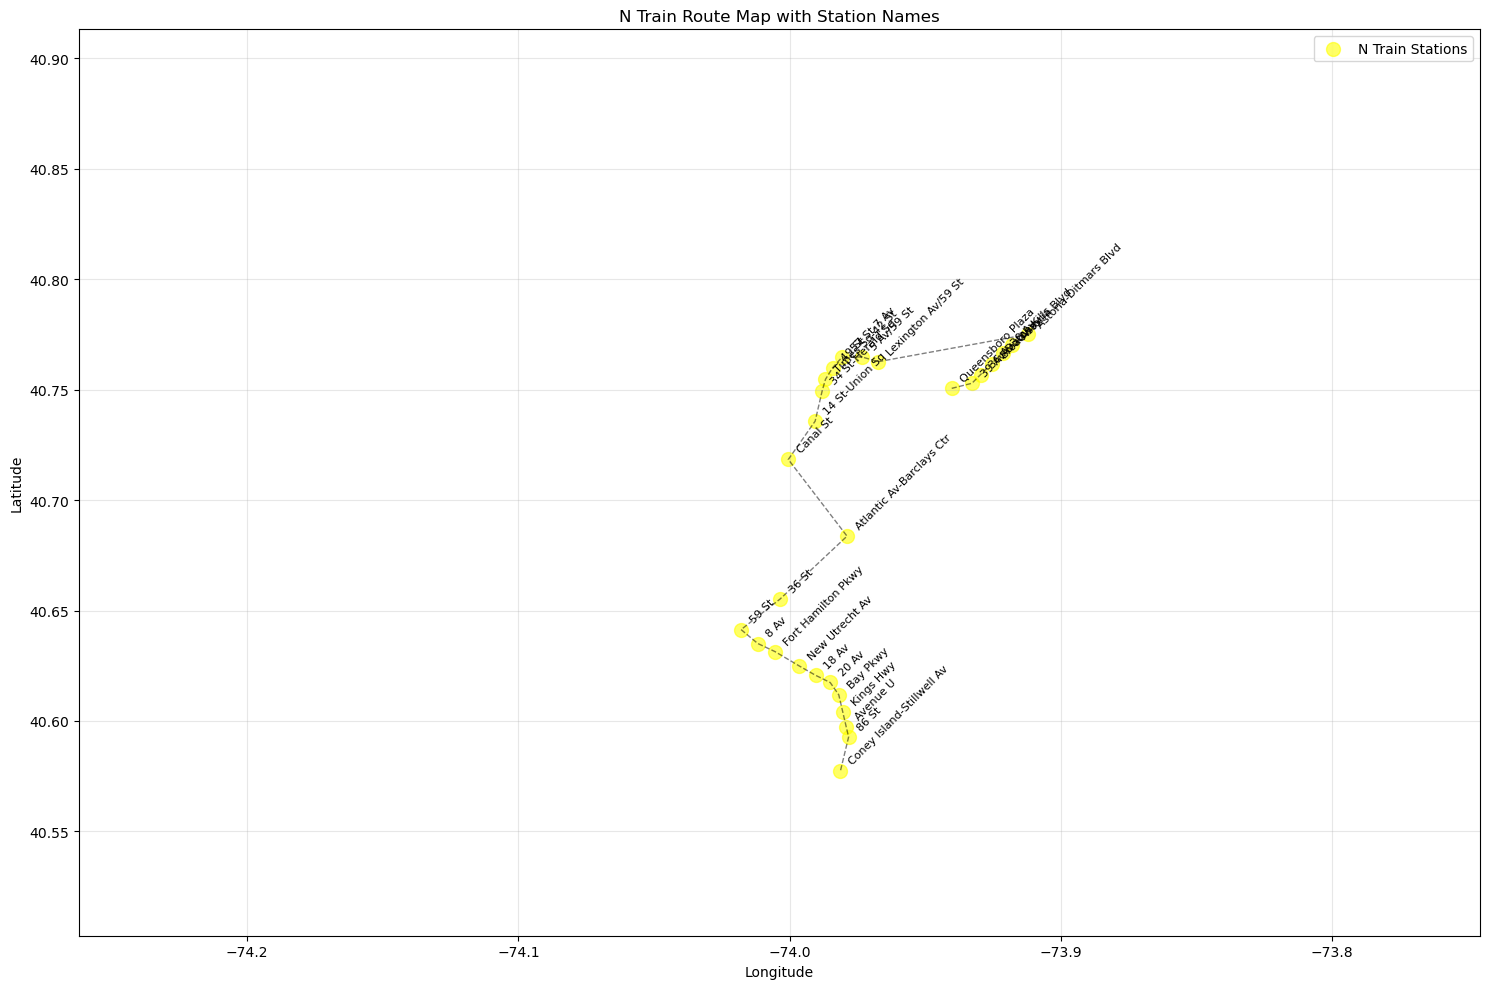

In [636]:
curr_line = unique_lines[16]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='yellow',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 6)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

[28, 27, 26, 25, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


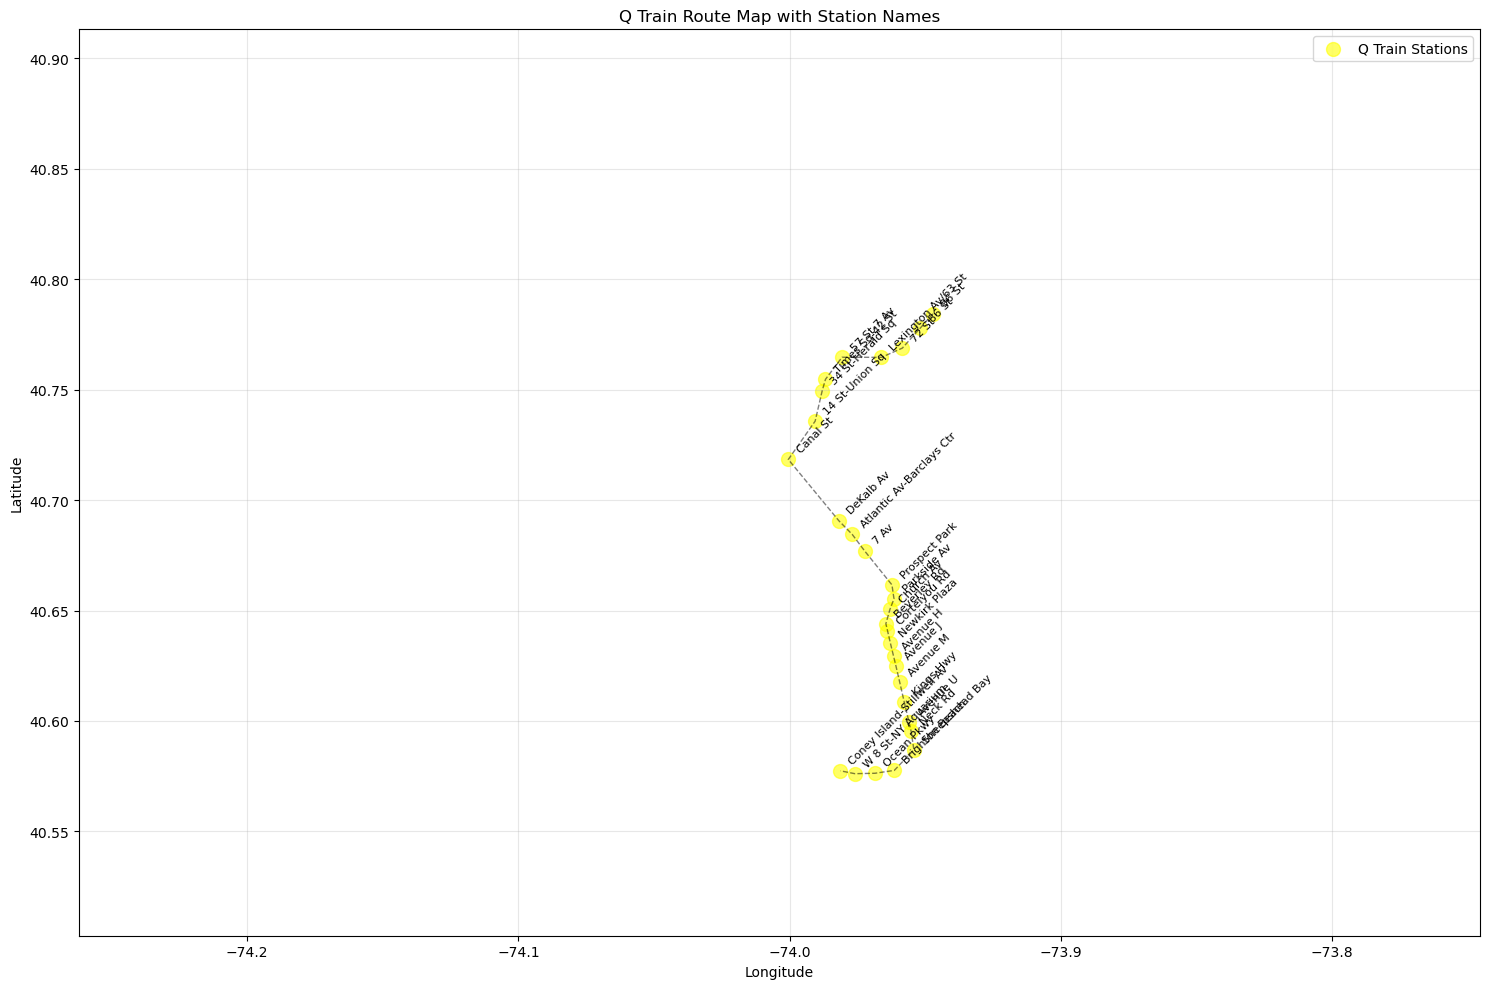

In [637]:
curr_line = unique_lines[17]
plt.figure(figsize=(15, 10))

# Plot all stations in orange
cur_train = train_lines[curr_line]
plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='yellow',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

    # Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix, 28)
# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()

# Sort by the Path we Found (like we did for F train)
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [638]:
train_lines['R']

,GTFS Stop ID,Station ID,Complex ID,Division,Line,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
0,R11,7,613,BMT,Astoria,Lexington Av/59 St,M,True,N R W,Subway,40.762660,-73.967258,Queens,Downtown,0,0,0,NaN,POINT (-73.967258 40.76266)
1,R13,8,8,BMT,Astoria,5 Av/59 St,M,True,N R W,Subway,40.764811,-73.973347,Queens,Downtown,0,0,0,NaN,POINT (-73.973347 40.764811)
2,R14,9,9,BMT,Broadway - Brighton,57 St-7 Av,M,True,N Q R W,Subway,40.764664,-73.980658,Uptown,Downtown,1,1,1,NaN,POINT (-73.980658 40.764664)
3,R15,10,10,BMT,Broadway - Brighton,49 St,M,True,N R W,Subway,40.759901,-73.984139,Uptown,Downtown,2,1,0,Uptown only,POINT (-73.984139 40.759901)
4,R16,11,611,BMT,Broadway - Brighton,Times Sq-42 St,M,True,N Q R W,Subway,40.754672,-73.986754,Uptown,Downtown,1,1,1,NaN,POINT (-73.986754 40.754672)
5,R17,12,607,BMT,Broadway - Brighton,34 St-Herald Sq,M,True,N Q R W,Subway,40.749567,-73.987950,Uptown,Downtown,1,1,1,NaN,POINT (-73.98795 40.749567)
6,R18,13,13,BMT,Broadway - Brighton,28 St,M,True,R W,Subway,40.745494,-73.988691,Uptown,Downtown,0,0,0,NaN,POINT (-73.988691 40.745494)
7,R19,14,14,BMT,Broadway - Brighton,23 St,M,True,R W,Subway,40.741303,-73.989344,Uptown,Downtown,0,0,0,NaN,POINT (-73.989344 40.741303)
8,R20,15,602,BMT,Broadway - Brighton,14 St-Union Sq,M,True,N Q R W,Subway,40.735736,-73.990568,Uptown,Downtown,1,1,1,NaN,POINT (-73.990568 40.735736)
9,R21,16,16,BMT,Broadway - Brighton,8 St-NYU,M,True,R W,Subway,40.730328,-73.992629,Uptown,Downtown,0,0,0,NaN,POINT (-73.992629 40.730328)


In [639]:
curr_line = unique_lines[18]  # Let's see what this line actually is
print(f"Current line: {curr_line}")

# Plot all stations in orange
cur_train = train_lines[curr_line]

# Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix)

# Sort by the Path we Found
train_lines[curr_line] = train_lines[curr_line].iloc[path].reset_index(drop=True)

# View the sorted DataFrame for the current line
print("\nSorted DataFrame:")
train_lines[curr_line]  # Use curr_line instead of 'R'

train_lines[curr_line] = train_lines[curr_line].drop(train_lines[curr_line].index[45:])

train_lines[curr_line]

cur_train = train_lines[curr_line]

# Create array of coordinates
coords = cur_train[['GTFS Latitude', 'GTFS Longitude']].values

# Calculate pairwise distances between all stations
distances = pdist(coords)
distance_matrix = squareform(distances)

# Get the ordered indices
path = nearest_neighbor_path(distance_matrix)

Current line: R

Sorted DataFrame:


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]


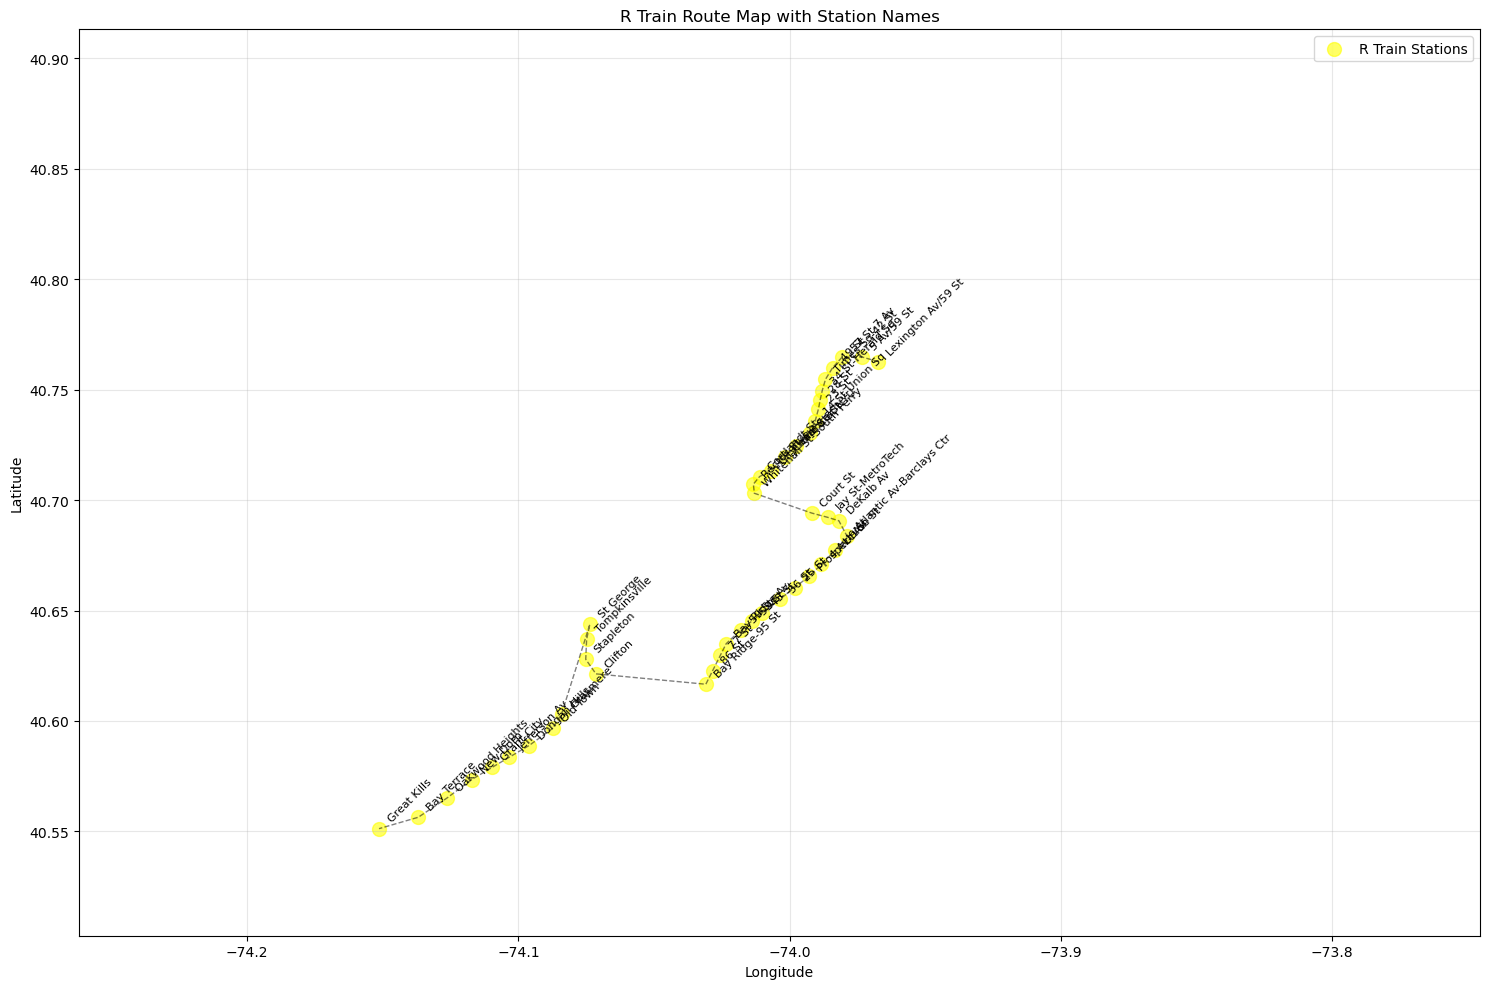

In [640]:
plt.figure(figsize=(15, 10))

plt.scatter(
    cur_train['GTFS Longitude'], 
    cur_train['GTFS Latitude'],
    color='yellow',  # Set color to orange
    alpha=0.6,
    s=100,
    label= curr_line + ' Train Stations'
)

# Add station names
for idx, row in cur_train.iterrows():
    plt.annotate(
        row['Stop Name'],
        (row['GTFS Longitude'], row['GTFS Latitude']),
        xytext=(5, 5),
        textcoords='offset points',
        fontsize=8,
        rotation=45,
        ha='left'
    )

# Connect stations with lines using the path
ordered_coords = coords[path]
plt.plot(
    ordered_coords[:, 1],  # Longitude
    ordered_coords[:, 0],  # Latitude
    'k--',  # Keep the connecting line black and dashed
    alpha=0.5,
    linewidth=1
)

print(path)
cur_data = train_lines[line]
cur_data.head()


plt.xlim(lon_min, lon_max)
plt.ylim(lat_min, lat_max)

plt.title(f'{curr_line} Train Route Map with Station Names')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()